# Installing dependencies

##### follow these steps to install cuda parts: <br> <br>  conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0 <br>  <br> conda create py310 python=3.10 <br> <br>   # Anything above 2.10 is not supported on the GPU on Windows Native <br> python -m pip install "tensorflow<2.11" <br> <br> # Verify the installation: <br> import tensorflow as tf <br>  print(tf.config.list_physical_devices('GPU'))

##### then <br> pip install -r req.txt

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Custom F1 score function
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

##### loading and resampling the file

In [3]:
def load_wav_16k_mono(file_path):
    
    #load encoded wav file
    file_content=tf.io.read_file(file_path)

    #decode wav file(in tensor, with channels)
    wav, sample_rate=tf.audio.decode_wav(file_content, desired_channels=1)

    #removing trailing axis
    wav=tf.squeeze(wav, axis=-1)

    #casting sample_rate to int64
    sample_rate=tf.cast(sample_rate, dtype=tf.int64)

    #changing the sample rate to 16k
    wav=tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)

    return wav

#### creating and visualising sample files

tf.Tensor(
[ 8.9910554e-07 -2.7947258e-06  7.0741157e-06 ... -1.0823049e-02
 -3.5766482e-03  1.5143131e-02], shape=(48000,), dtype=float32)


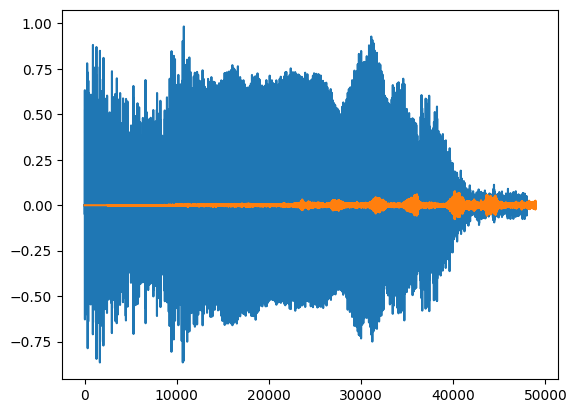

In [4]:
SAMPLE_CAPUCHIN_BIRD=os.path.join(r'D:\projects\audio_classifier\dataset\Parsed_Capuchinbird_Clips',r'XC3776-3.wav')
SAMPLE_NOT_CAPUCHIN_BIRD=os.path.join(r'D:\projects\audio_classifier\dataset\Parsed_Not_Capuchinbird_Clips',r'afternoon-birds-song-in-forest-0.wav')

wave=load_wav_16k_mono(SAMPLE_CAPUCHIN_BIRD)
nwave=load_wav_16k_mono(SAMPLE_NOT_CAPUCHIN_BIRD)
print(wave)

wave_offset = wave - np.min(wave)
nwave_offset = nwave - np.min(nwave)

# Plot the shifted data
plt.plot(wave)
plt.plot(nwave)

plt.show()

#### creating and labelling the dataset

In [5]:
POS_path=os.path.join(r'D:\projects\audio_classifier\dataset', r'Parsed_Capuchinbird_Clips')
NEG_path=os.path.join(r'D:\projects\audio_classifier\dataset', r'Parsed_Not_Capuchinbird_Clips')

In [6]:
pos=tf.data.Dataset.list_files(POS_path+'\*.wav')
neg=tf.data.Dataset.list_files(NEG_path+'\*.wav')

In [7]:
pos.as_numpy_iterator().next()

b'D:\\projects\\audio_classifier\\dataset\\Parsed_Capuchinbird_Clips\\XC227471-2.wav'

In [8]:
positives=tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives=tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [9]:
data.shuffle(1000).as_numpy_iterator().next()

(b'D:\\projects\\audio_classifier\\dataset\\Parsed_Not_Capuchinbird_Clips\\magpies-and-crows-cawing-sound-effect-8.wav',
 0.0)

#### Determine Average Length of a Capuchin Call
##### by Calculating Mean, Min and Max

In [10]:
lengths = []
for file in os.listdir(POS_path):
    tensor_wave = load_wav_16k_mono(os.path.join(POS_path, file))
    lengths.append(len(tensor_wave))

In [11]:
print(tf.math.reduce_mean(lengths))
print(tf.math.reduce_min(lengths))
print(tf.math.reduce_max(lengths))
print(np.median(lengths))

tf.Tensor(54156, shape=(), dtype=int32)
tf.Tensor(32000, shape=(), dtype=int32)
tf.Tensor(80000, shape=(), dtype=int32)
56000.0


#### building a preprocessing fucntion

In [12]:
def preprocess(file_path, label):
    #using the resample function
    wav= load_wav_16k_mono(file_path)

    #taking the first 56000 samples out of all samples
    wav= wav[:56000]

    #creating a padding of zeros for the files which has less than 56k samples
    zero_padding= tf.zeros([56000] - tf.shape(wav), dtype=tf.float32)

    #concatinating the padding and the file
    wav= tf.concat([zero_padding, wav], 0)

    #creating a short term fourier transform
    spectogram= tf.signal.stft(wav, frame_length=320, frame_step=32)

    #absoluting the values(removing the -ve no.)
    spectogram= tf.abs(spectogram)

    #expanding the dimensions
    spectogram= tf.expand_dims(spectogram, axis=2)

    return spectogram, label

#### testing the function and visualising the spectogram

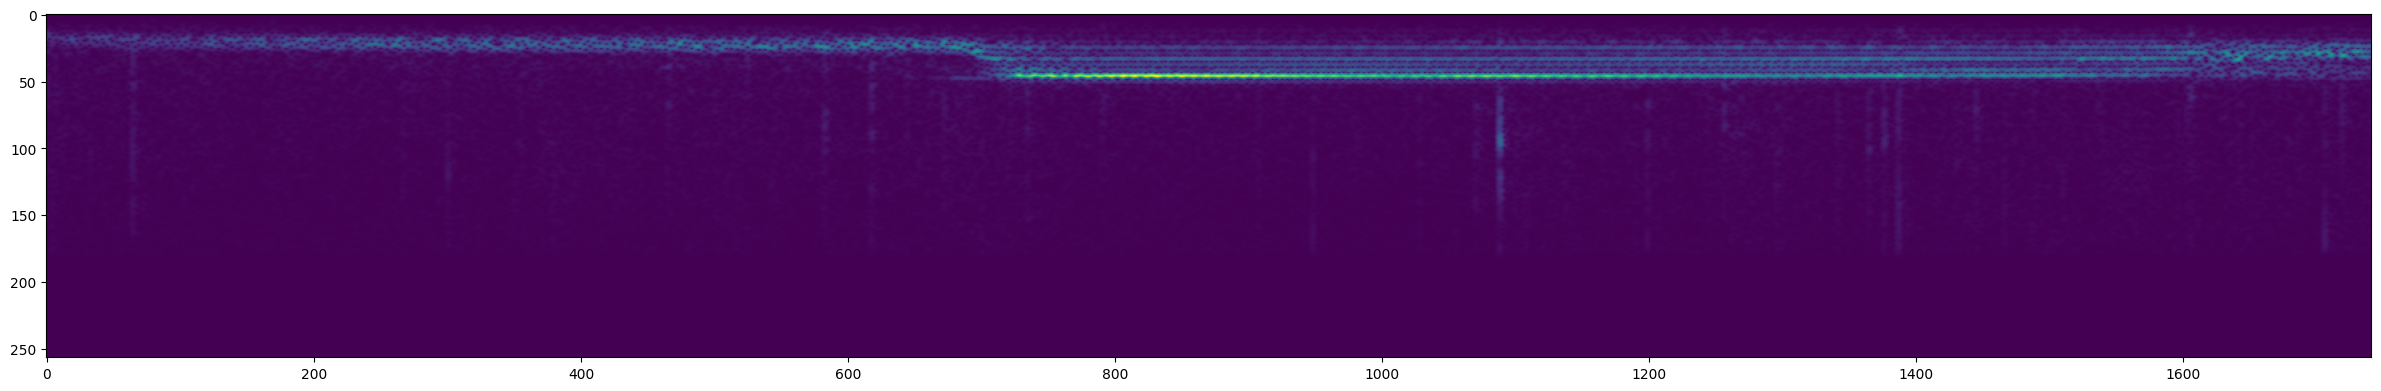

In [13]:
file_path, label= positives.shuffle(10000).as_numpy_iterator().next()
spectogram, label= preprocess(file_path, label)

plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

#### creating a tf data pipeline

In [14]:
data= data.map(preprocess)
data= data.cache()
data= data.shuffle(1000)
data= data.batch(16)
data= data.prefetch(tf.data.experimental.AUTOTUNE)

#### splitting into training and testing

In [15]:
len(data)

51

In [16]:
train= data.take(41)
test= data.skip(41).take(10)

In [17]:
sample, label= train.as_numpy_iterator().next()
print(sample.shape)
print(label)

(16, 1741, 257, 1)
[1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]


#### building the deep learning model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras import mixed_precision
from tensorflow import keras 

In [19]:
# # Enable memory growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

# # Use mixed precision
# mixed_precision.set_global_policy('mixed_float16')

# # Reduce model complexity
# model = Sequential([
#     Conv2D(2, (3,3), activation='relu', input_shape=(1741, 257, 1)),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

In [20]:
# model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [21]:
# model.summary()

##### total parameters: 56 million

# new-model

In [22]:
# Enable memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Use mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Reduce model complexity
model = Sequential([
    Conv2D(2, (3,3), activation='relu', input_shape=(1741, 257, 1)),
    Conv2D(2, (3,3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile('Adam', loss='BinaryCrossentropy', metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.Accuracy(), F1Score()
])
model.summary()

Physical devices cannot be modified after being initialized
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1739, 255, 2)      20        
                                                                 
 conv2d_1 (Conv2D)           (None, 1737, 253, 2)      38        
                                                                 
 flatten (Flatten)           (None, 878922)            0         
                                                                 
 dense (Dense)               (None, 64)                56251072  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 56,251,195
Trainable params: 56,251,195
Non-trainable params: 0
_________________________________________________________________


#### fitting model

In [23]:
history= model.fit(train, epochs=100, validation_data=test)

Epoch 1/100
41/41 [==============================] - 16s 102ms/step - loss: 7.5745 - recall: 0.7072 - precision: 0.8767 - accuracy: 0.7790 - f1_score: 0.7829 - val_loss: 0.7532 - val_recall: 1.0000 - val_precision: 0.8974 - val_accuracy: 0.8117 - val_f1_score: 0.9459
Epoch 2/100
41/41 [==============================] - 3s 84ms/step - loss: 0.3404 - recall: 0.9451 - precision: 0.9556 - accuracy: 0.8963 - f1_score: 0.9503 - val_loss: 0.1077 - val_recall: 1.0000 - val_precision: 0.9778 - val_accuracy: 0.8442 - val_f1_score: 0.9888
Epoch 3/100
41/41 [==============================] - 4s 92ms/step - loss: 0.1800 - recall: 1.0000 - precision: 0.9312 - accuracy: 0.7927 - f1_score: 0.9644 - val_loss: 0.0262 - val_recall: 1.0000 - val_precision: 1.0000 - val_accuracy: 0.8312 - val_f1_score: 1.0000
Epoch 4/100
41/41 [==============================] - 4s 91ms/step - loss: 0.0487 - recall: 0.9941 - precision: 1.0000 - accuracy: 0.7637 - f1_score: 0.9970 - val_loss: 0.0372 - val_recall: 1.0000 - va

In [24]:
history.history

{'loss': [7.574509143829346,
  0.3403676748275757,
  0.17996227741241455,
  0.04867890477180481,
  0.029738793149590492,
  0.02385874092578888,
  0.010256585665047169,
  0.0038255525287240744,
  0.0018726892303675413,
  0.0008417629869654775,
  0.0004519747453741729,
  0.0003332844644319266,
  0.0002433861227473244,
  0.00018681403889786452,
  0.000116524170152843,
  0.00011886038555530831,
  9.349497122457251e-05,
  9.870820213109255e-05,
  7.724761962890625e-05,
  4.1304563637822866e-05,
  6.504466000478715e-05,
  4.864902075496502e-05,
  4.157206058152951e-05,
  2.1591418772004545e-05,
  3.227664274163544e-05,
  2.629001028253697e-05,
  1.691027318884153e-05,
  1.8159063984057866e-05,
  2.4115166525007226e-05,
  2.4782448235782795e-05,
  1.9234854335081764e-05,
  2.1220706912572496e-05,
  2.1316656784620136e-05,
  1.4776136595173739e-05,
  1.6462512576254085e-05,
  1.6647141819703393e-05,
  1.694661841611378e-05,
  9.493130164628383e-06,
  1.4957858184061479e-05,
  1.175519901153165

#### plotting loss

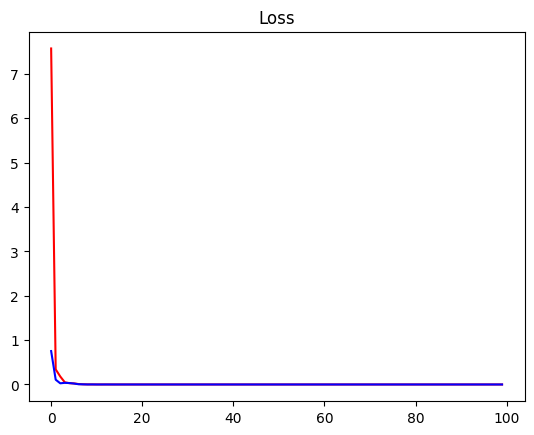

In [25]:
plt.title('Loss')
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.show()

In [29]:
precisions = history.history['precision']
precision = sum(precisions) / len(precisions)

print(precision)

0.9976348483562469


In [30]:
recalls= history.history['recall']
recall = sum(recalls)/len(recalls)

print(recall)

0.9964632016420364


In [31]:
accuracys= history.history['accuracy']
accuracy = sum(accuracys)/len(accuracys)

print(accuracy)

0.9579268318414688


In [32]:
f1_scores= history.history['f1_score']
f1_score = sum(f1_scores)/len(f1_scores)

print(f1_score)

0.996945669054985


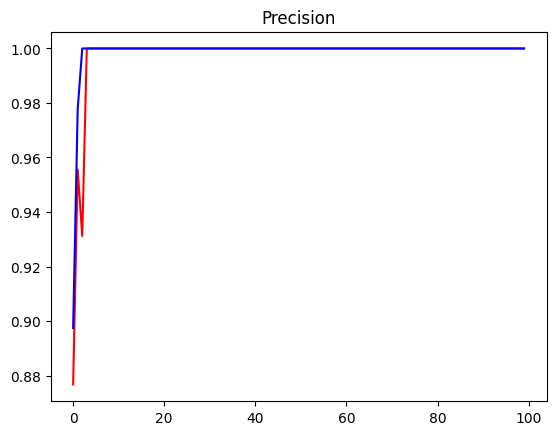

In [33]:
plt.title('Precision')
plt.plot(history.history['precision'], 'r')
plt.plot(history.history['val_precision'], 'b')
plt.show()

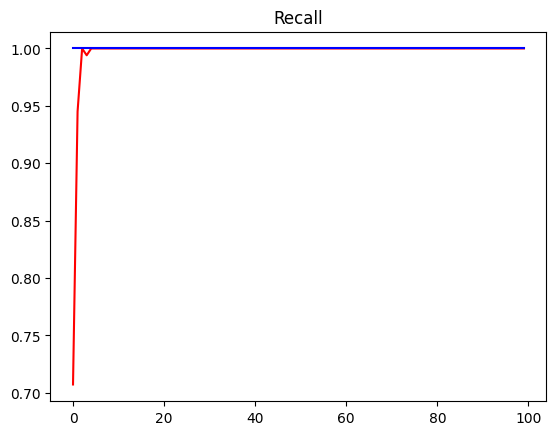

In [34]:
plt.title('Recall')
plt.plot(history.history['recall'], 'r')
plt.plot(history.history['val_recall'], 'b')
plt.show()

#### getting one batch and making a prediction

In [35]:
x_test, y_test= test.as_numpy_iterator().next()
print(x_test.shape)
print(y_test.shape)

(16, 1741, 257, 1)
(16,)


In [36]:
y_pred= model.predict(x_test)
y_pred

1/1 [==============================] - 0s 424ms/step


array([[0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.]], dtype=float16)

In [37]:
Y_pred=[]
for prediction in y_pred:
    if prediction > 0.5:
        Y_pred.append(1)
    else:
        Y_pred.append(0)

# or you can write it like this with the same list
# y_pred=[1 if prediction > 0.5 else 0 for prediction in y_pred]

Y_pred

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

##### small testing

In [38]:
# checking no. of +ve prediction we got
print(np.sum(Y_pred))
print(int(np.sum(y_test)))

# checking the mapping of classes
yap='true'
for x,y in zip(y_test, Y_pred):
    if x==y:
        yap='true'
    else:
        yap='false'
print(yap)

2
2
true


## working with the long forest recordings

In [39]:
def load_mp3_16k_mono(file_path):
    # Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio.
    
    res = tfio.audio.AudioIOTensor(file_path)
    
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
   
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

##### some understanding and visualisation through code

In [40]:
mp3 = os.path.join(r'D:\projects\audio_classifier\dataset', r'Forest Recordings', r'recording_10.mp3')

In [41]:
res = tfio.audio.AudioIOTensor(mp3)
print(res)
tensor = res.to_tensor()
tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
tensor

<AudioIOTensor: shape=[8642000       2], dtype=<dtype: 'float32'>, rate=48000>


<tf.Tensor: shape=(8642000,), dtype=float32, numpy=
array([-6.0293314e-07, -2.3570406e-05, -2.5176483e-05, ...,
       -2.9089598e-03, -5.3040916e-03, -5.5155628e-03], dtype=float32)>

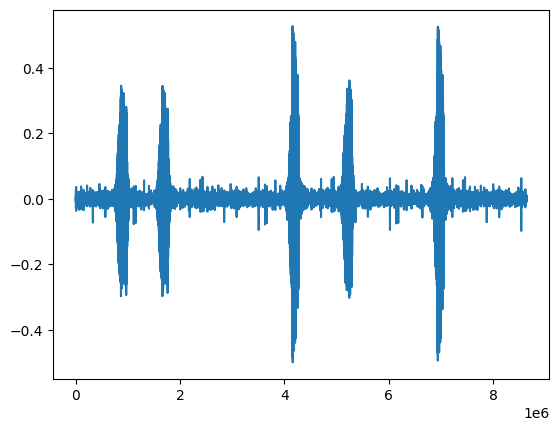

In [42]:
plt.plot(tensor)

In [43]:
MP3=load_mp3_16k_mono(mp3)
MP3

<tf.Tensor: shape=(2880666,), dtype=float32, numpy=
array([ 4.6576228e-12, -2.4573427e-11,  2.5731894e-10, ...,
       -2.0440691e-03, -1.0853980e-03, -9.9355727e-04], dtype=float32)>

In [44]:
audio_slices= tf.keras.utils.timeseries_dataset_from_array(MP3, MP3, sequence_length=56000, sequence_stride=56000, batch_size=1)

In [45]:
len(audio_slices)

51

In [46]:
samples, index= audio_slices.as_numpy_iterator().next()

In [47]:
samples.shape

(1, 56000)

In [48]:
def preprocess_mp3(sample, index):
    # taking the 1st row here
    sample= sample[0]

    # creating a padding of zeroes
    zero_padding= tf.zeros([56000] - tf.shape(sample), dtype=tf.float32)

    # concatinating them
    mp3= tf.concat([zero_padding, sample], 0)

    #using short term fourier transform again
    spectrogram= tf.signal.stft(mp3, frame_length=320, frame_step=32)

    #absoluting the values
    spectrogram = tf.abs(spectrogram)

    #expanding dimensions
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram

In [49]:
audio_slices= audio_slices.map(preprocess_mp3)
audio_slices= audio_slices.batch(64)

In [50]:
y_pred=model.predict(audio_slices)
y_pred= [1 if prediction>0.99 else 0 for prediction in y_pred]

1/1 [==============================] - 1s 1s/step


In [51]:
print(np.sum(y_pred))
y_pred

9


[0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

#### grouping consecutive detections

In [52]:
from itertools import groupby

y_pred = [key for key, group in groupby(y_pred)]
calls = tf.math.reduce_sum(y_pred).numpy()

In [53]:
calls

5

#### making predictions for all the files

In [54]:
results={}

files=os.listdir(os.path.join(r'D:\projects\audio_classifier\dataset', r'Forest Recordings'))
for file in files:
    file_path= os.path.join(r'D:\projects\audio_classifier\dataset', r'Forest Recordings', file)

    mp3= load_mp3_16k_mono(file_path)
    audio_slices= tf.keras.utils.timeseries_dataset_from_array(mp3, mp3, sequence_length=56000, sequence_stride=56000, batch_size=1)
    audio_slices= audio_slices.map(preprocess_mp3)
    audio_slices= audio_slices.batch(64)

    y_pred= model.predict(audio_slices)

    results[file]= y_pred

1/1 [==============================] - 0s 493ms/step


In [55]:
results

{'recording_00.mp3': array([[0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [0.0000e+00],
        [1.1414e-04],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [6.3629e-03],
        [0.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [0.0000e+00],
        [6.9904e-04],
        [0.0000e+00],
        [0.0000e+00],
        [7.9036e-05],
        [2.5725e-04],
        [0.0000e+00],
        [0.0000e+00],
        [8.9746e-01],
        [1.0000e+00],
        [1.1593e-04],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [0.0000e+00],
        [3.5810e-04],
        [0.0000e+00],
        [0.0

In [56]:
class_pred= {}

for file, logits in results.items():
    class_pred[file]= [1 if prediction>0.99 else 0 for prediction in logits]

class_pred

{'recording_00.mp3': [0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [57]:
post_processed= {}

for file, scores in class_pred.items():
    post_processed[file]= tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()

post_processed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 5,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 9,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 5,
 'recording_17.mp3': 3,
 'recording_18.mp3': 12,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 3,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 12,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 7,
 'recording_29.mp3': 0,
 'recording_30.mp3': 4,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 1,
 'recording_39.mp3': 8,
 'recording_40.mp3': 1,
 'recording_41

#### exporting into a csv

In [58]:
import csv

with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'No._of_capuchin_calls'])
    for key, value in post_processed.items():
        writer.writerow([key, value])